# Croissant 🥐 Online Health Report

## Example of [hf.co/datasets](https://huggingface.co/datasets)

This notebook is based on the output produced after crawling [huggingface.co/datasets](https://huggingface.co/datasets). See the README for more details.

At the moment, we only crawl Hugging Face which is why the report is custom for Hugging Face. We will enrich other repositories in the future (Kaggle, OpenML). The goal here is to make the Croissant ecosystem better by analyzing issues.

In [1]:
import sys

from etils import epath
from IPython.display import Markdown
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns

sns.set()

source = "huggingface"  # Name of the scrapy spider

folder = epath.Path(sys.path[0]) / "../data"
files = folder.glob("*/*.parquet")
df = pl.scan_parquet(files).filter(pl.col("source") == source)

print(f"Report for {source}")

Report for huggingface


## 1. Responses overview

Scrapped 150210 datasets for huggingface

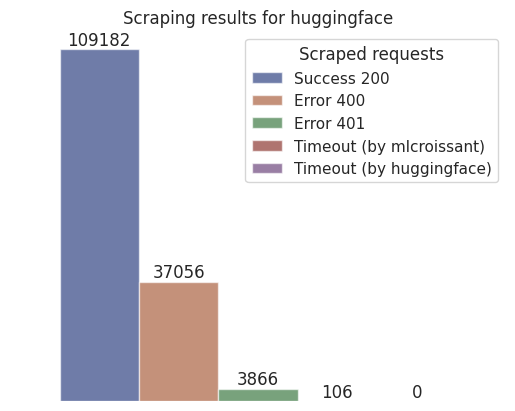

In [2]:
sns.set_style("white")

num_rows = df.select(pl.len()).collect().item()
display(Markdown(f"Scrapped {num_rows} datasets for {source}"))

has_timeout = pl.col("timeout_seconds").is_not_null()
has_croissant_timeout = pl.col("croissant_timeout_seconds").is_not_null()
data = df.filter(~has_timeout & ~has_croissant_timeout).group_by(pl.col("response_status")).len().sort(by="len", descending=True).collect()
num_timeouts = df.filter(has_timeout & ~has_croissant_timeout).select(pl.len()).collect().item()
num_croissant_timeouts = df.filter(~has_timeout & has_croissant_timeout).select(pl.len()).collect().item()
labels = [f"Success {code}" if code == 200 else f"Error {code}" for code in data["response_status"]] + [f"Timeout (by {source})"] + ["Timeout (by mlcroissant)"]
data = list(data["len"]) + [num_timeouts] + [num_croissant_timeouts]
data = {'Scraped requests': labels, 'Number': data}
hue_order = [element[1] for element in sorted(zip(data["Number"], data["Scraped requests"]), reverse=True)]
ax = sns.barplot(y='Number', hue='Scraped requests', data=data, palette="dark", alpha=.6, hue_order=hue_order)
ax.set(yticklabels=[])
ax.set(ylabel=None)
for i in ax.containers:
    ax.bar_label(i,)
plt.title(f"Scraping results for {source}")
sns.despine(left=True, bottom=True)
plt.show()

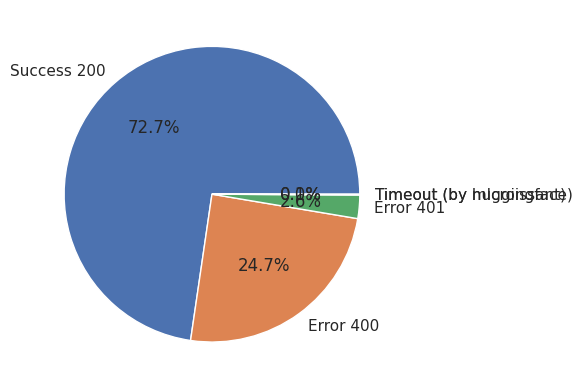

In [3]:
plt.pie(data["Number"], labels=data["Scraped requests"], autopct='%1.1f%%')
plt.show()

## 2. Croissant statistics

For the moment, we only count the number of `cr:Field`, `cr:RecordSet`, etc. We will enrich with more signals in the future.

In [4]:
columns = [
    "croissant_num_fields",
    "croissant_num_file_objects",
    "croissant_num_file_sets",
    "croissant_num_record_sets",
]
for column in columns:
    display(df.select(pl.col(column)).collect().describe(percentiles=[]))

statistic,croissant_num_fields
str,f64
"""count""",109167.0
"""null_count""",41043.0
"""mean""",7.760431
"""std""",50.790145
"""min""",0.0
"""max""",1761.0


statistic,croissant_num_file_objects
str,f64
"""count""",109167.0
"""null_count""",41043.0
"""mean""",1.0
"""std""",0.0
"""min""",1.0
"""max""",1.0


statistic,croissant_num_file_sets
str,f64
"""count""",109167.0
"""null_count""",41043.0
"""mean""",1.203899
"""std""",4.117753
"""min""",0.0
"""max""",100.0


statistic,croissant_num_record_sets
str,f64
"""count""",109167.0
"""null_count""",41043.0
"""mean""",1.203899
"""std""",4.117753
"""min""",0.0
"""max""",100.0


## 3. In-depth errors

We now try to deep dive into the errors to understand why it fails.

In [5]:
# Report by type of errors

# List of errors that we currently know
CURRENTLY_KNOWN_ERRORS = [
    "<twisted.python.failure.Failure twisted.internet.error.TimeoutError",
    '{"error":"The dataset viewer doesn\'t support this dataset because it runs arbitrary python code.',
    '{"error":"The dataset does not exist, or is not accessible without authentication (private or gated).',
    '{"error":"The dataset is empty."',
]

rows_with_errors = ~has_timeout & ~has_croissant_timeout & pl.col("response_status") != 200
data = df.filter(rows_with_errors).group_by(pl.col("response_status")).agg(pl.col("body")).collect()
for row in data.rows(named=True):
    if row["response_status"] != 200:
        display(Markdown(f"### Status {row['response_status']}"))
        known_errors, unknown_errors = [], []
        for error in row["body"]:
            error = error.decode()
            if any(error.startswith(known_error) for known_error in CURRENTLY_KNOWN_ERRORS):
                known_errors.append(error)
            else:
                unknown_errors.append(error)
        if known_errors:
            display(Markdown(f"#### Known errors"))
            for error in known_errors[:10]:
                display(Markdown(f"- {error}"))
        if unknown_errors:
            display(Markdown(f"#### Unknown errors"))
            for error in unknown_errors[:10]:
                display(Markdown(f"- {error}"))

### Status 400

#### Unknown errors

- {"error":"The croissant format is not available for this dataset."}

- {"error":"The croissant format is not available for this dataset."}

- {"error":"The croissant format is not available for this dataset."}

- {"error":"The croissant format is not available for this dataset."}

- {"error":"The croissant format is not available for this dataset."}

- {"error":"The croissant format is not available for this dataset."}

- {"error":"The croissant format is not available for this dataset."}

- {"error":"The croissant format is not available for this dataset."}

- {"error":"The croissant format is not available for this dataset."}

- {"error":"The croissant format is not available for this dataset."}

### Status 401

#### Unknown errors

- {"error":"Invalid username or password."}

- {"error":"Invalid username or password."}

- {"error":"Access to dataset oscar-corpus/colossal-oscar-1.0 is restricted. You must be authenticated to access it."}

- {"error":"Access to dataset indra-inc/docvqa_en_full_train_valid_processed_gtparse is restricted. You must be authenticated to access it."}

- {"error":"Access to dataset AlekseyKorshuk/crowdsource-v2.0 is restricted. You must be authenticated to access it."}

- {"error":"Access to dataset AlekseyKorshuk/crowdsource-v2.0-prompts is restricted. You must be authenticated to access it."}

- {"error":"Access to dataset yeye776/autotrain-data-brokarry_intent_poc is restricted. You must be authenticated to access it."}

- {"error":"Access to dataset vietgpt-archive/Cong-Thong-Tin-Dien-Tu-Thanh-Pho-Da-Nang is restricted. You must be authenticated to access it."}

- {"error":"Access to dataset pufanyi/MIMICIT is restricted. You must be authenticated to access it."}

- {"error":"Access to dataset vietgpt-archive/thuvienphapluat_qa_vi is restricted. You must be authenticated to access it."}

In [6]:
# Report by occurrence

rows_with_errors = ~has_timeout & ~has_croissant_timeout & pl.col("response_status") != 200
data = df.filter(rows_with_errors).group_by([pl.col("response_status"), pl.col("body")]).len().sort(by="len", descending=True).collect()

errors = data.filter(pl.col("response_status") != 200)
for error in errors.rows(named=True):
    if error["len"] > 5:
        display(Markdown(f"- **[{error['len']} similar errors]** [code {error['response_status']}]: {error['body'].decode()[:1000]}"))

- **[37056 similar errors]** [code 400]: {"error":"The croissant format is not available for this dataset."}

- **[89 similar errors]** [code 401]: {"error":"Invalid username or password."}